# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [107]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache


In [108]:
pd.set_option("display.max_columns",200)
pd.set_option("display.max_rows",5000)


download_base = Path('C:\\Users\\jwilk\\merFISH_Data') # Path to where you would like to write the downloaded data.
abc_cache = AbcProjectCache.from_s3_cache(download_base)

abc_cache.load_manifest('releases/20230630/manifest.json')

abc_cache.list_data_files('MERFISH-C57BL6J-638850')

file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850', file_name='C57BL6J-638850/log2')
adata = anndata.read_h5ad(file, backed='r')

cell = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='cell_metadata',
    dtype={"cell_label": str}
)
cell.set_index('cell_label', inplace=True)

cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)
cluster_details.set_index('cluster_alias', inplace=True)

cluster_colors = abc_cache.get_metadata_dataframe(directory='WMB-taxonomy', file_name='cluster_to_cluster_annotation_membership_color')
cluster_colors.set_index('cluster_alias', inplace=True)

cell_extended = cell.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias')
cell_extended.head(5)


pred = (cell_extended['brain_section_label'] == 'C57BL6J-638850.44')
section = cell_extended[pred]

ntgenes = ['Slc17a7', 'Rbp4']

gnames = ntgenes
pred = [x in gnames for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
asubset = adata[:, gene_filtered.index].to_memory()
print(asubset)
start = time.time()

C:\Users\jwilk\anaconda3\Lib\site-packages\abc_atlas_access\abc_atlas_cache\cloud_cache.py:626: OutdatedManifestWarning: You are loading releases/20230630/manifest.json. A more up to date version of the dataset -- releases/20241115/manifest.json -- exists online. To see the changes between the two versions of the dataset, run
type.compare_manifests('releases/20230630/manifest.json', 'releases/20241115/manifest.json')
To load another version of the dataset, run
type.load_manifest('releases/20241115/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


AnnData object with n_obs × n_vars = 4330907 × 2
    obs: 'brain_section_label'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'normalization', 'parent', 'parent_layer'


In [109]:
print(cluster_details.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5196 entries, 1 to 5411
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   neurotransmitter  5196 non-null   object
 1   division          5196 non-null   object
 2   class             5196 non-null   object
 3   subclass          5196 non-null   object
 4   supertype         5196 non-null   object
 5   cluster           5196 non-null   object
dtypes: object(6)
memory usage: 284.2+ KB
None


In [110]:
def unique_types(cell_extended, class_level, neurotransmitter, gene):
    entries = []
    x = 0
    index = 0
    
    #print(cell_extended)
    for x in range(cell_extended.shape[0] - 1):
        #print(cell_extended['supertype'][x])
        if gene in cell_extended[class_level].iloc[int(x)]:
            entry = cell_extended.iloc[int(x)]
            entries.append(entry)
            
        #unique_set.add(cell_extended['supertype'][x])
        #test_list = pd.DataFrame(entry)
    print(len(entries))
    chosen_df = pd.DataFrame(entries)
    chosen_df.rename(columns= {0: 'cell_label'})
    #chosen_df.set_index('cell_label', inplace=True)
    print(chosen_df)
    return chosen_df

In [111]:
def create_expression_dataframe(ad, gf):
    
         
    
    gdata = ad[:, gf.index].to_df()
    gdata.info()
   
    gdata.columns = gf.gene_symbol
    print(gdata)
    joined = section.join(gdata)
    return joined
    


In [112]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped


In [113]:
def unique_types_by_gene(cell_extended, gene):
    entries = []
    x = 0
    index = 0
    
    #print(cell_extended)
    for x in range(cell_extended.shape[0] - 1):
        #print(cell_extended['supertype'][x])
        if cell_extended[gene].iloc[int(x)] > 0:
            entry = cell_extended.iloc[int(x)]
            entries.append(entry)
            
        #unique_set.add(cell_extended['supertype'][x])
        #test_list = pd.DataFrame(entry)
    print(len(entries))
    chosen_df = pd.DataFrame(entries)
    chosen_df.rename(columns= {0: 'cell_label'})
    #chosen_df.set_index('cell_label', inplace=True)
    print(chosen_df)
    return chosen_df

In [114]:
def join_NT():
    pred = [x in ntgenes for x in asubset.var.gene_symbol]

    gf = asubset.var[pred]

    ntexp = create_expression_dataframe(asubset, gf)
    #ntexp.info()
    
    #agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'neurotransmitter')
    #agg = agg[ntgenes]
    
    return ntexp


In [115]:
def plot_heatmap(df, fig_width = 8, fig_height = 4, cmap = plt.cm.magma_r):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=5)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

In [116]:
def plot_section(xx, yy, cc = None, val = None, fig_width = 8, fig_height = 8, cmap = None):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return fig, ax



In [117]:
def fraction_by_layers(test_list, total_list):
    substring = ['l1', 'l2/3', 'l4', 'l5', 'l6']
    
    for i in range(len(substring)):
        filtered_test_list = test_list[test_list['cluster_annotation_term_name'].str.contains(substring[i])]
        print(filtered_test_list)
        print("----------------")

<class 'pandas.core.frame.DataFrame'>
Index: 4330907 entries, 1015221640100570419 to 1018145707100390249
Data columns (total 2 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ENSMUSG00000024990  float64
 1   ENSMUSG00000070570  float64
dtypes: float64(2)
memory usage: 228.1+ MB
gene_symbol              Rbp4   Slc17a7
cell_label                             
1015221640100570419  1.544775  0.000000
1015221640100590598  0.000000  0.000000
1015221640100820600  1.180946  0.000000
1015221640100580476  0.000000  0.000000
1015221640100580189  0.000000  0.000000
...                       ...       ...
1018145707100250222  0.000000  1.903645
1018145707100250185  0.000000  1.794017
1018145707100430302  0.000000  0.000000
1018145707100430291  0.000000  0.000000
1018145707100390249  0.000000  3.044648

[4330907 rows x 2 columns]
65614
                    brain_section_label  cluster_alias  \
1020131842102200844   C57BL6J-638850.44           4090   
102013184210220016

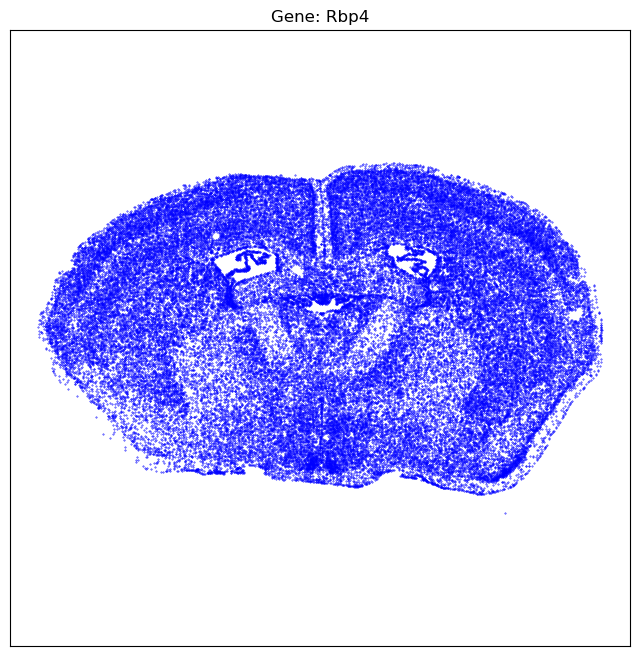

In [118]:
test_list = unique_types_by_gene(join_NT(), 'Rbp4')
total_list = join_NT()

end = time.time()
for x in range(test_list.shape[0] - 1):
    if test_list['Rbp4'].iloc[x] == 0:
        print("problem")
        

    
fig, ax = plot_section(test_list['x'], test_list['y'], 'blue')
res = ax.set_title("Gene: Rbp4")

print(total_list.info())

    
print ("code time", end - start)

In [119]:
file = ("C:\\Users\\jwilk\\Desktop\\cluster_to_cluster_annotation_membership (6).csv")
cluster_details_layers = pd.read_csv(file, index_col=0)
#cluster_details_layers.set_index('cluster_alias', inplace=True)

yo = pd.DataFrame.copy(test_list)
yo = yo.merge(cluster_details_layers[['cluster_alias', 'cluster_annotation_term_name']], on='cluster_alias', how='left')
test = yo.groupby('cluster_alias')
yo['cluster_annotation_term_name'] = yo.groupby('cluster_alias')['cluster_annotation_term_name'].transform('first')



total_list = total_list.merge(cluster_details_layers[['cluster_alias', 'cluster_annotation_term_name']], on='cluster_alias', how='left')
test = total_list.groupby('cluster_alias')
total_list['cluster_annotation_term_name'] = total_list.groupby('cluster_alias')['cluster_annotation_term_name'].transform('first')


fraction_by_layers(yo, total_list)


#print(yo[['cluster_alias', 'cluster_annotation_term_name']])


Empty DataFrame
Columns: [brain_section_label, cluster_alias, average_correlation_score, matrix_label, donor_label, low_quality_mapping, donor_genotype, donor_sex, x, y, z, neurotransmitter, division, class, subclass, supertype, cluster, neurotransmitter_color, division_color, class_color, subclass_color, supertype_color, cluster_color, Rbp4, Slc17a7, cluster_annotation_term_name]
Index: []
----------------
Empty DataFrame
Columns: [brain_section_label, cluster_alias, average_correlation_score, matrix_label, donor_label, low_quality_mapping, donor_genotype, donor_sex, x, y, z, neurotransmitter, division, class, subclass, supertype, cluster, neurotransmitter_color, division_color, class_color, subclass_color, supertype_color, cluster_color, Rbp4, Slc17a7, cluster_annotation_term_name]
Index: []
----------------
Empty DataFrame
Columns: [brain_section_label, cluster_alias, average_correlation_score, matrix_label, donor_label, low_quality_mapping, donor_genotype, donor_sex, x, y, z, neuro

In [120]:
substring = ['l1', 'l2/3', 'l4', 'l5', 'l6']

fractional_layers = []
for i in range(len(substring)):
    filtered_test_list = yo[yo['cluster_annotation_term_name'].str.contains(substring[i], case=False)]
    filtered_total_list = total_list[total_list['cluster_annotation_term_name'].str.contains(substring[i], case=False)]
    if (filtered_total_list.shape[0] != 0):
        fractional_layers.append(filtered_test_list.shape[0]/filtered_total_list.shape[0])
        print(filtered_test_list.shape[0])
        print(filtered_total_list.shape[0])
        print(filtered_test_list.shape[0]/filtered_total_list.shape[0])
        print("----------------")
print(fractional_layers)

29898
46338
0.6452155897967111
----------------
32922
45828
0.718381775333857
----------------
16536
23448
0.7052200614124872
----------------
34146
48870
0.6987108655616943
----------------
[0.6452155897967111, 0.718381775333857, 0.7052200614124872, 0.6987108655616943]


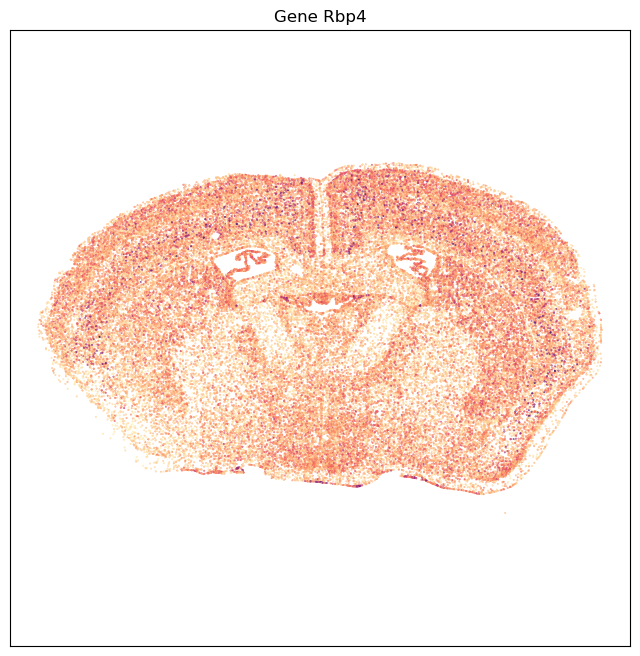

In [122]:
fig, ax = plot_section(test_list['x'], test_list['y'], val=test_list['sl'], cmap=plt.cm.magma_r)
res = ax.set_title('Gene Rbp4')
plt.show()